In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ujipenchars2
import string
import random
import itertools
from drawing import Drawing
from preprocessing import DrawingToBoxScaler, DrawingResampler, VideoCreator
#from dtw import dtw, dtw_distance_matrix
from PIL import Image, ImageDraw, ImageFilter, ImageOps
from video_to_tensor import video_to_tensor
import tensorly as tl
from IPython.core.display import HTML
from collections import defaultdict
np.random.seed(0)

In [2]:
def plot_results(labels, predictions):
    
    df = pd.concat((labels, predictions), axis=1)
    counts = df.groupby(list(df.columns)).size().unstack(fill_value=0)

    images = (
        (counts.div(counts.sum(axis=1), axis=0), 'Raspored znamenaka po predikcijama'), # normaliziramo po retcima
        (counts.div(counts.sum(axis=0)), 'Sastav predviđenih znamenki'), # normaliziramo po stupcima
    )
    plt.figure(figsize=(12, 6))
    for i in range(len(images)):
        plt.subplot(1, 2, i + 1)
        plt.imshow(images[i][0], cmap='Reds', vmin=0, vmax=1, origin='lower')
        plt.title(images[i][1])
        plt.xlabel('Predikcija')
        plt.xticks(range(counts.shape[1]), counts.columns)
        plt.ylabel('Znamenka')
        plt.yticks(range(counts.shape[0]), counts.index)

In [3]:
n=28
n_frames = 5

In [4]:
train, test = ujipenchars2.Parser('data/ujipenchars2').parse(string.digits)

drawing_scaler = DrawingToBoxScaler(0.05,0.95,0.05,0.95)
train = drawing_scaler.transform(train)
test = drawing_scaler.transform(test)
video_creator=VideoCreator(n_frames)

In [5]:
A=defaultdict(list)
a=defaultdict(list)
for drawing in train:
    tensor=video_to_tensor(video_creator.transform_one(drawing),base_resolution=300,real_resolution=28,line_width=20)
    A[int(drawing.label)].append(tensor)
    a[int(drawing.label)].append(tensor[n_frames-1])

In [6]:
for i in range(10):
    print(f'len(A[{i}])={len(A[i])}')

len(A[0])=80
len(A[1])=80
len(A[2])=80
len(A[3])=80
len(A[4])=80
len(A[5])=80
len(A[6])=80
len(A[7])=80
len(A[8])=80
len(A[9])=80


# HOSVD za slike znamenki

In [7]:
for i in range(10):
    a[i]=np.stack(a[i], axis=0, out=None)

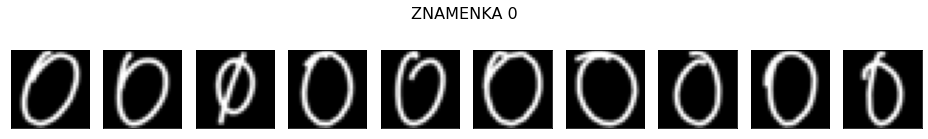

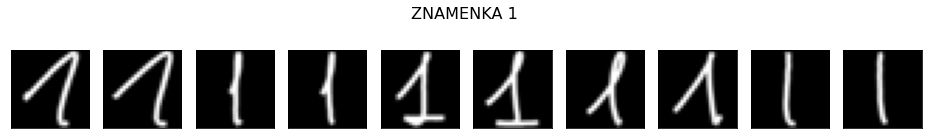

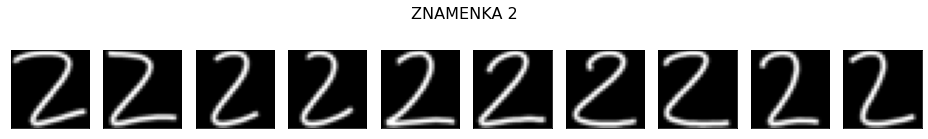

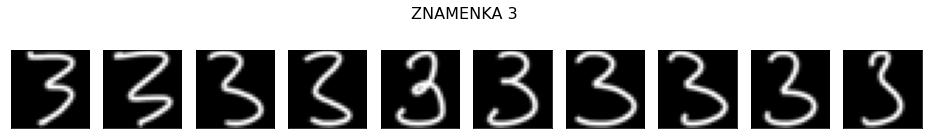

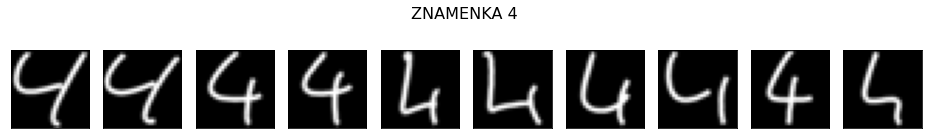

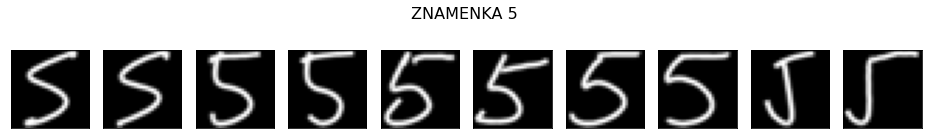

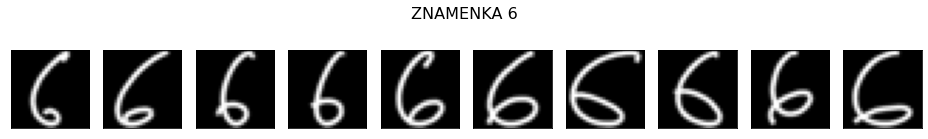

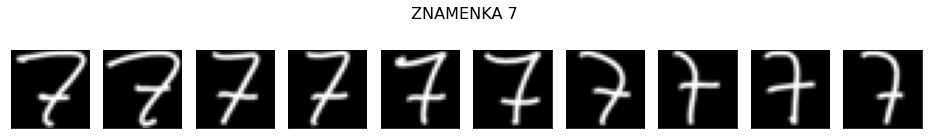

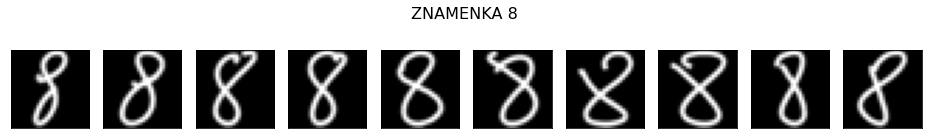

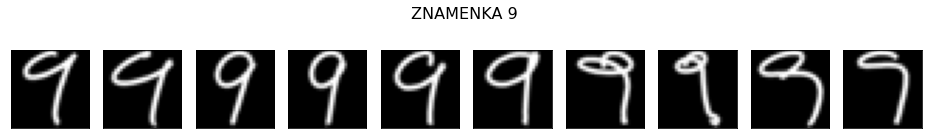

In [8]:
for j in range(10):
    fig=plt.figure(figsize=(13, 2))
    fig.suptitle(f'ZNAMENKA {j}',fontsize=16)
    for i in range(10):
        plt.subplot(1, 10, i + 1)
        plt.imshow(a[j][i], cmap='gray', vmin=0, vmax=255)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()

Wall time: 1.67 s


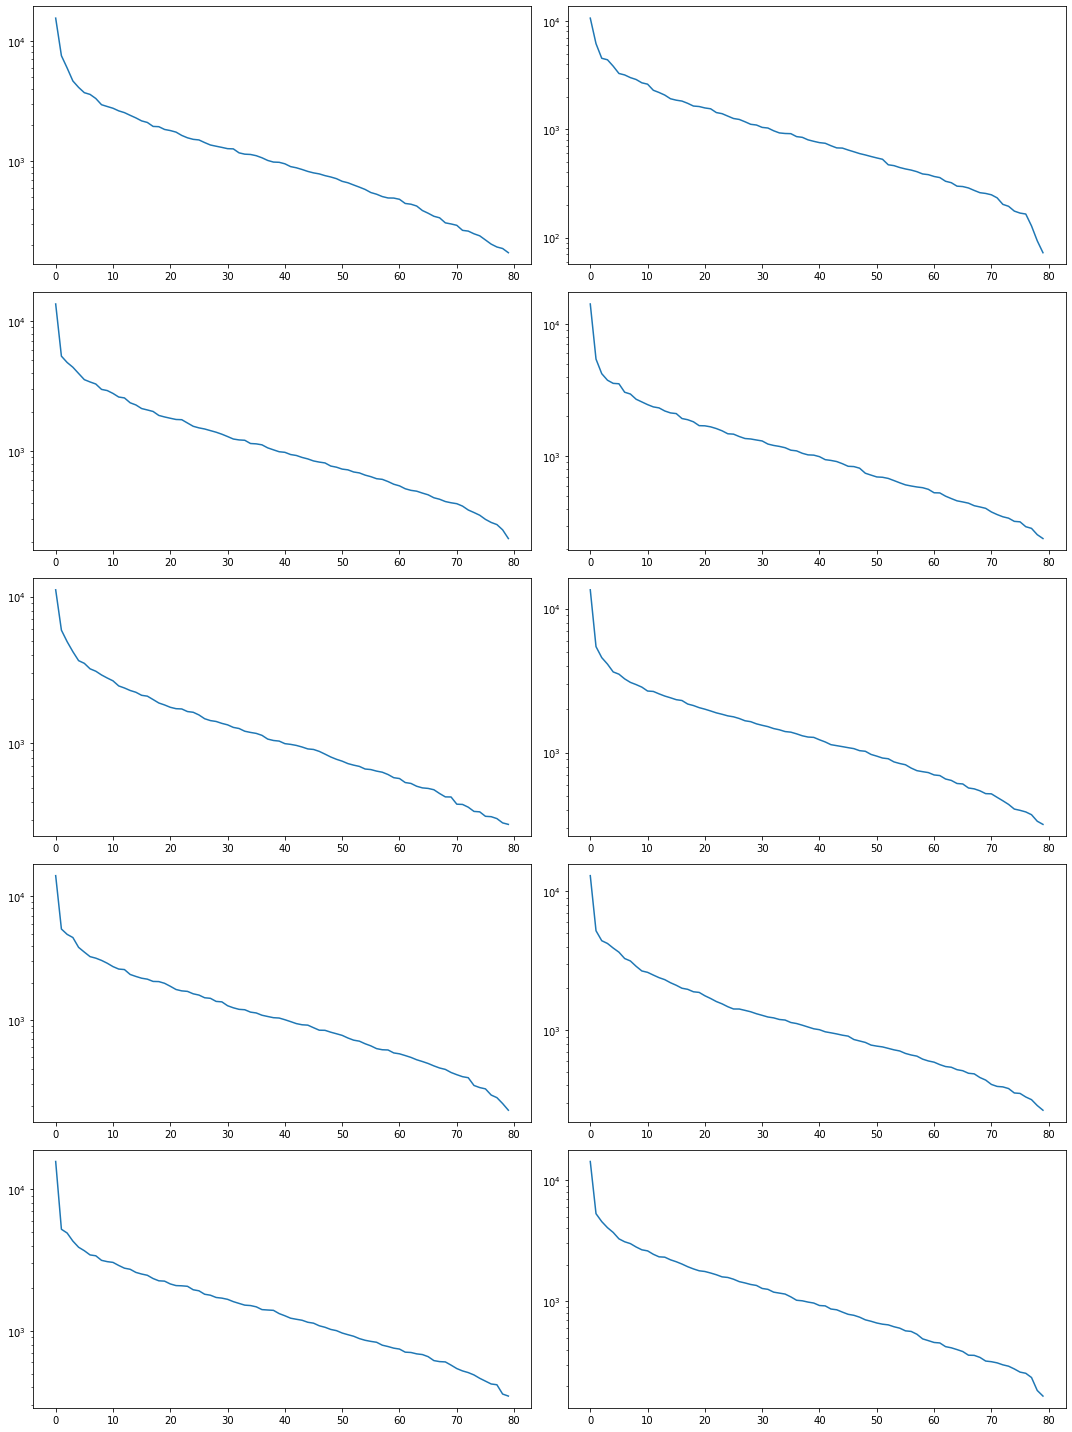

In [9]:
%%time
display(HTML('<h2>Norme odsječaka jezgrenih tenzora u modu 3</h2>'))
from tensorly.decomposition import tucker
core,factors={},{}
m=[]
plt.figure(figsize=(15,20))
for i in range(10):
    a[i]=np.transpose(a[i],axes=[1,2,0])
    third_dim=min(n**2,np.shape(a[i])[2])
    core[i], factors[i] = tucker(a[i],rank=[n,n,third_dim])
    s=[]
    first=1
    for j in range(third_dim):
        s.append(np.linalg.norm(core[i][:,:,j],'fro'))
        if(s[j]<1e-06 and first):
            m.append(j)
            first=0
    if(first==1):
        m.append(third_dim)
        
    plt.subplot(5,2,i+1)
    plt.semilogy(s)
    a[i]=np.transpose(a[i],axes=[2,0,1])
plt.tight_layout()

In [10]:
m

[80, 80, 80, 80, 80, 80, 80, 80, 80, 80]

In [11]:
%%time
S={}
for i in range(10):
    if(m[i]<np.shape(core[i])[2]):
        core[i]=core[i][:,:,:m[i]]
        factors[i][2]=factors[i][2][:,:m[i]]
    S[i]=[]
    for j in range(m[i]):
        s=tl.tenalg.multi_mode_dot(core[i][:,:,j],matrix_or_vec_list=[factors[i][0],factors[i][1]])
        s=s/np.linalg.norm(s,'fro')
        S[i].append(s)

Wall time: 56 ms


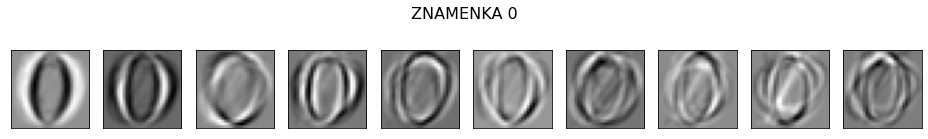

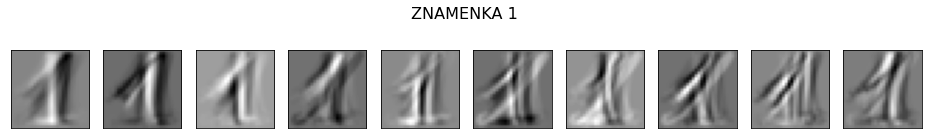

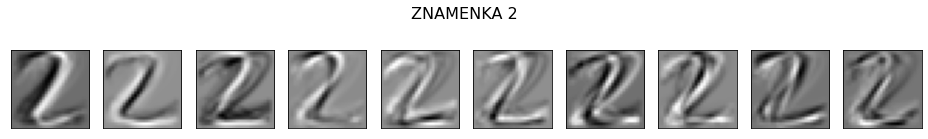

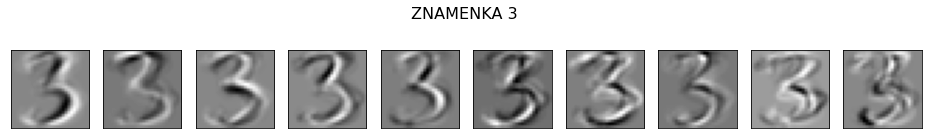

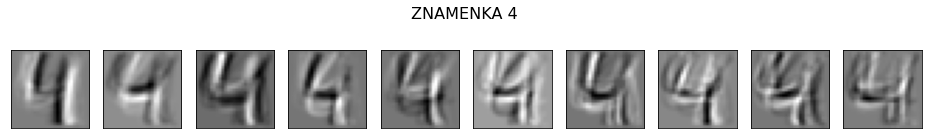

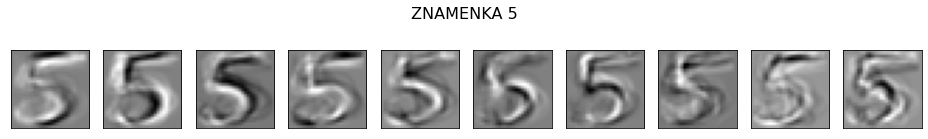

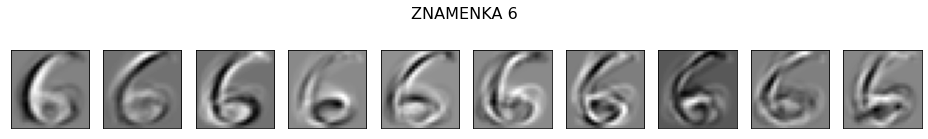

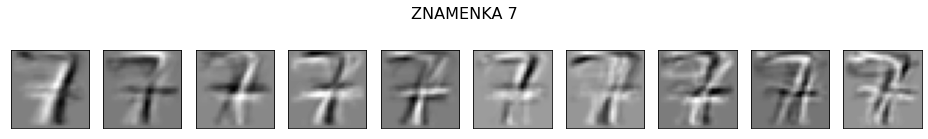

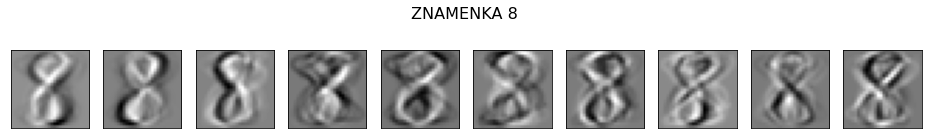

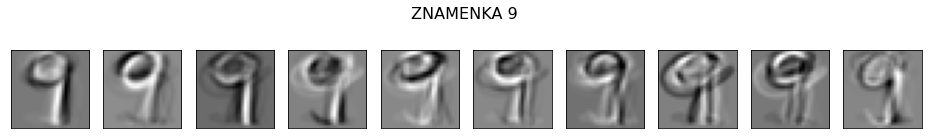

In [12]:
display(HTML('<h2>Komponente tenzorske dekompozicije za svaku znamenku</h2>'))
for j in range(10):
    fig=plt.figure(figsize=(13, 2))
    fig.suptitle(f'ZNAMENKA {j}',fontsize=16)
    for i in range(10):
        plt.subplot(1, 10, i + 1)
        plt.imshow(S[j][i+1],cmap='gray')
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()

In [13]:
%%time
test_predictions=[]
test_labels=[]
T=defaultdict(list)
for drawing in test:
    test_labels.append(int(drawing.label))
    Z=video_to_tensor(video_creator.transform_one(drawing),base_resolution=300,real_resolution=28,line_width=20)[n_frames-1]
    Z=Z/np.linalg.norm(Z,'fro')
    R=[]
    for j in range(10):
        E=1-sum((np.trace(S[j][k].T @ Z))**2 for k in range(80))
        R.append(E)
    test_predictions.append(np.argmin(R))
    T[np.argmin(R)].append(Z)

Wall time: 7.46 s


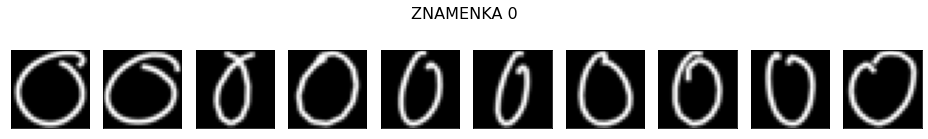

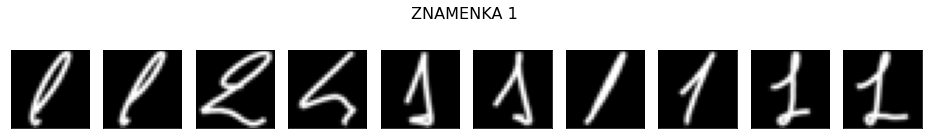

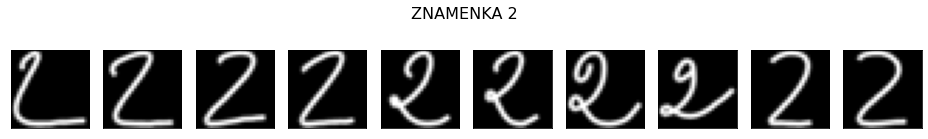

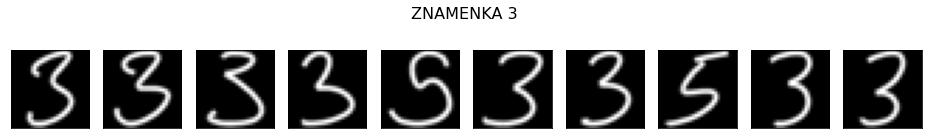

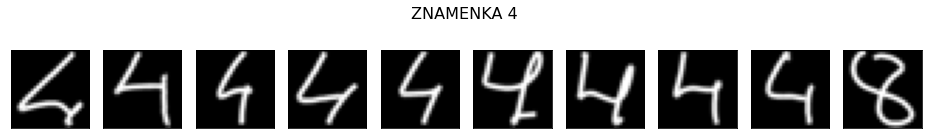

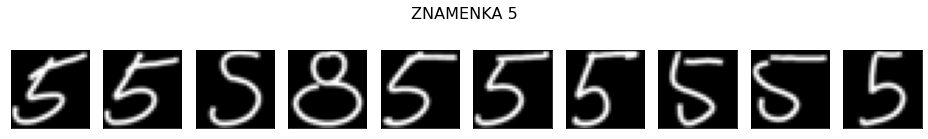

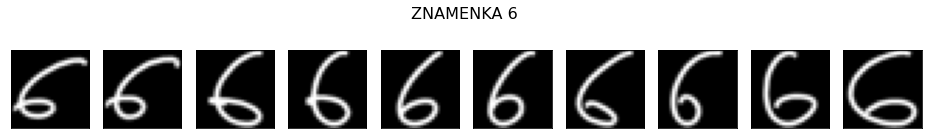

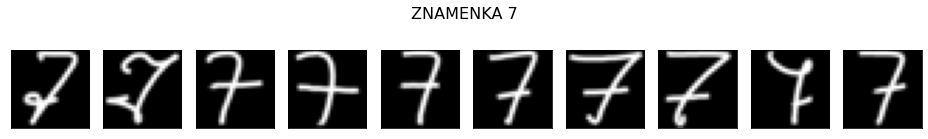

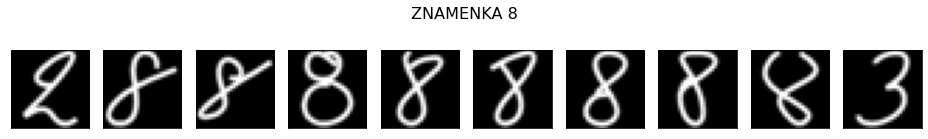

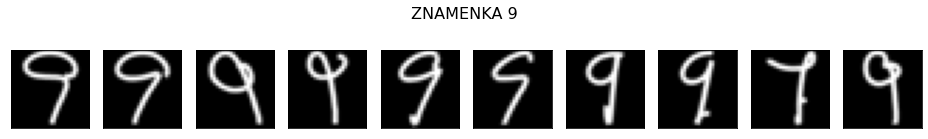

In [14]:
display(HTML('<h2>Predviđene znamenke</h2>'))
for i in range(10):
    fig=plt.figure(figsize=(13, 2))
    fig.suptitle(f'ZNAMENKA {i}',fontsize=16)
    for j in range(10):
        plt.subplot(1, 10, j + 1)
        plt.imshow(T[i][j],cmap='gray')
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()

In [15]:
print('Točnost je',round(np.sum((np.array(test_labels)==np.array(test_predictions)))/len(test)*100,1),'%.')

Točnost je 89.8 %.


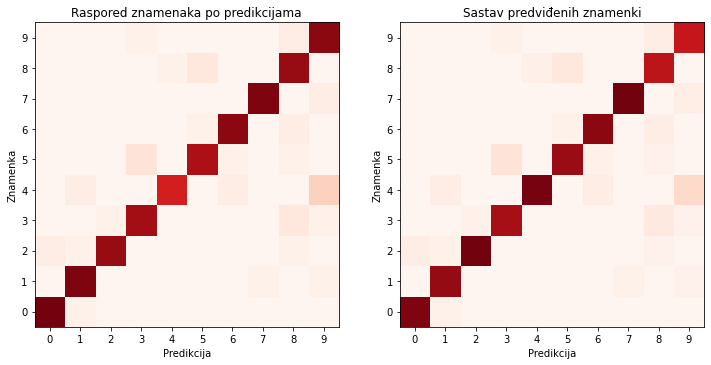

In [16]:
plot_results(pd.Series(test_labels), pd.Series(test_predictions))

# HOSVD za videe znamenki

In [17]:
for i in range(10):
    for j in range(len(A[i])):
        frames_list=[]
        for k in range(n_frames):
            frames_list.append(A[i][j][k].flatten())
        A[i][j]=np.stack(frames_list, axis=1)
    A[i]=np.stack(A[i], axis=0, out=None)

In [18]:
np.shape(A[0])

(80, 784, 5)

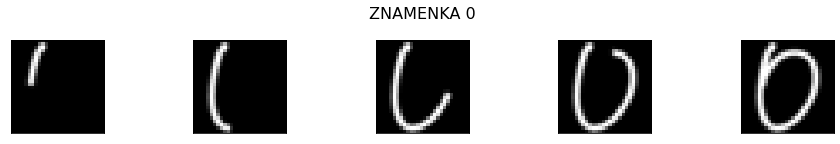

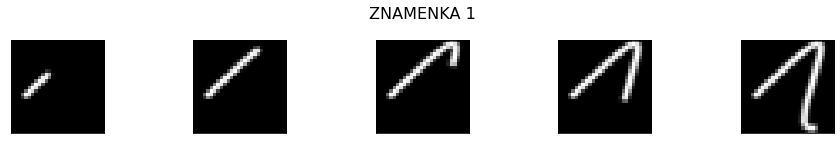

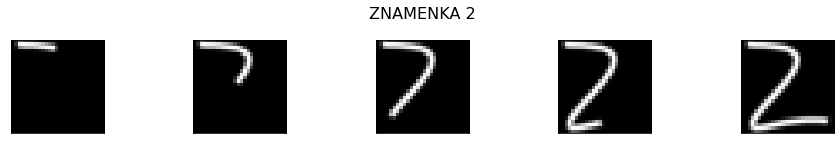

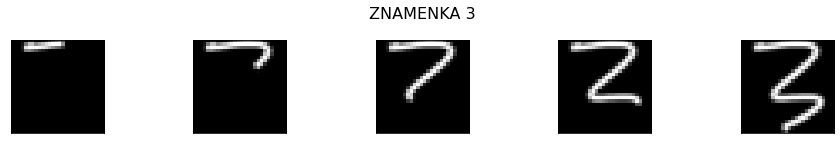

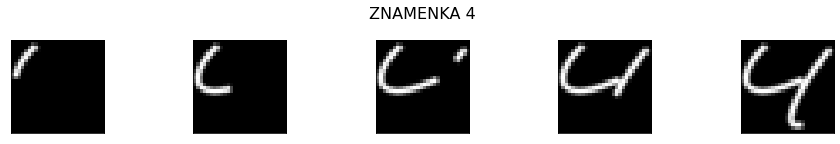

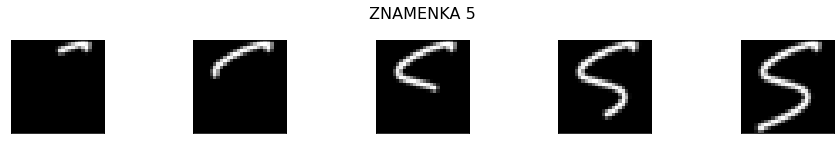

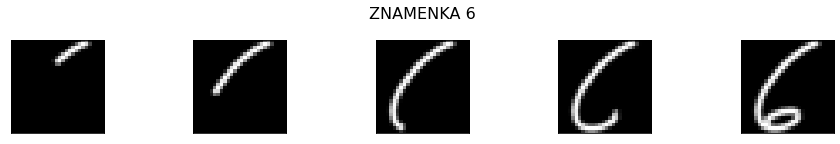

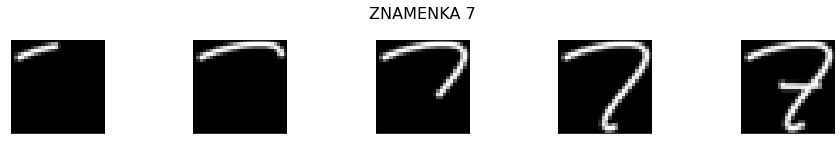

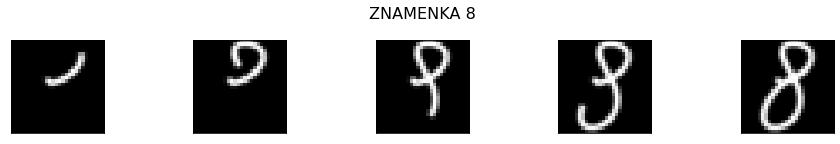

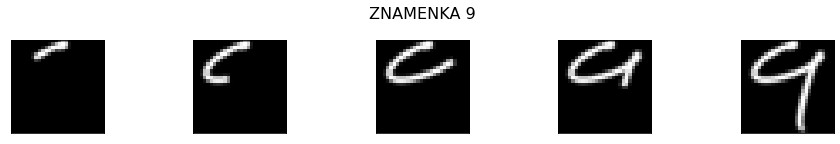

In [19]:
for j in range(10):
    fig=plt.figure(figsize=(13, 2))
    fig.suptitle(f'ZNAMENKA {j}',fontsize=16)
    for i in range(n_frames):
        plt.subplot(1, n_frames, i + 1)
        plt.imshow(A[j][1,:,i].reshape(n,n), cmap='gray', vmin=0, vmax=255)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()

Wall time: 3.06 s


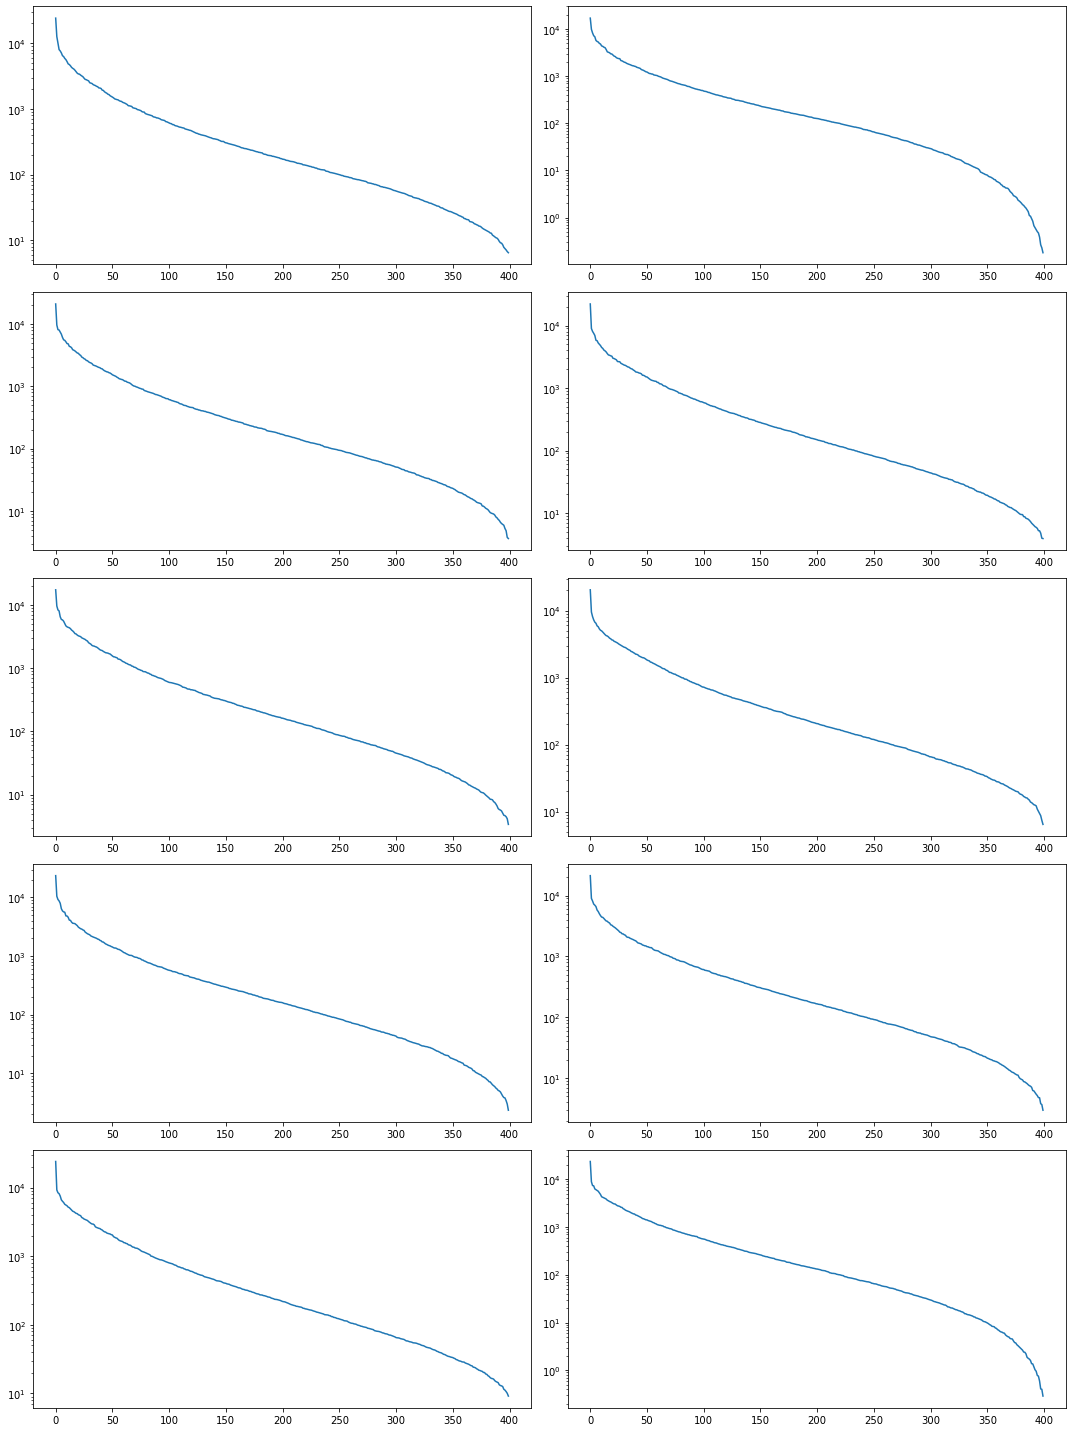

In [20]:
%%time
display(HTML('<h2>Norme odsječaka jezgrenih tenzora u modu 3</h2>'))
from tensorly.decomposition import tucker
core,factors={},{}
m=[]
plt.figure(figsize=(15,20))
for i in range(10):
    A[i]=np.transpose(A[i],axes=[1,2,0])
    first_dim=min(np.shape(A[i])[1]*np.shape(A[i])[2],np.shape(A[i])[0])
    core[i], factors[i] = tucker(A[i],rank=[first_dim,np.shape(A[i])[1],np.shape(A[i])[2]])
    s=[]
    first=1
    for j in range(first_dim):
        s.append(np.linalg.norm(core[i][j,:,:],'fro'))
        if(s[j]<1e-06 and first):
            m.append(j)
            first=0
    if(first==1):
        m.append(first_dim)
        
    plt.subplot(5,2,i+1)
    plt.semilogy(s)
    A[i]=np.transpose(A[i],axes=[2,0,1])
plt.tight_layout()

In [21]:
m

[400, 400, 400, 400, 400, 400, 400, 400, 400, 400]

In [22]:
%%time
S={}
for i in range(10):
    if(m[i]<np.shape(core[i])[0]):
        core[i]=core[i][:m[i],:,:]
        factors[i][0]=factors[i][0][:,:m[i]]
    S[i]=[]
    for j in range(np.shape(core[i])[2]):
        s=tl.tenalg.multi_mode_dot(core[i][:,:,j],matrix_or_vec_list=[factors[i][0],factors[i][1]])
        s=s/np.linalg.norm(s,'fro')
        S[i].append(s)

Wall time: 212 ms


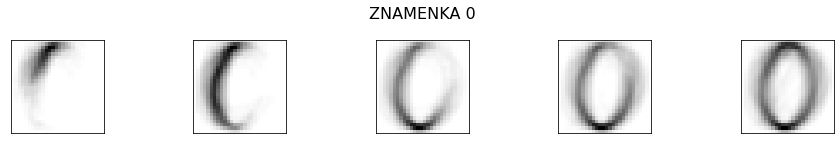

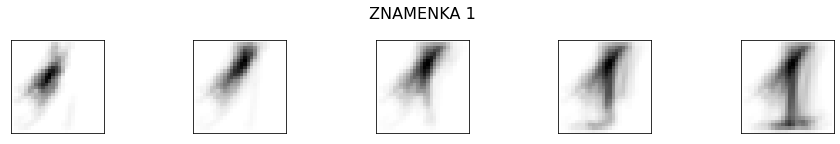

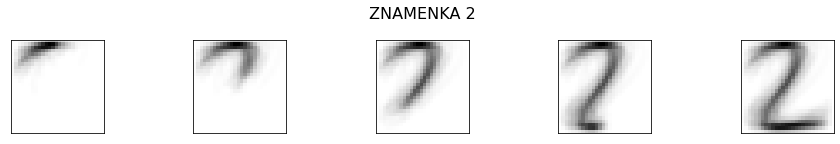

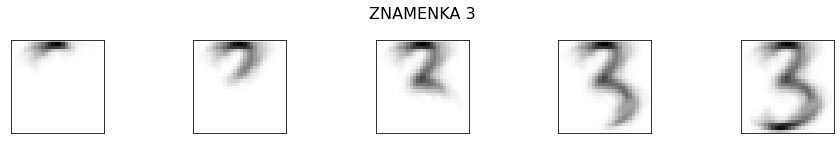

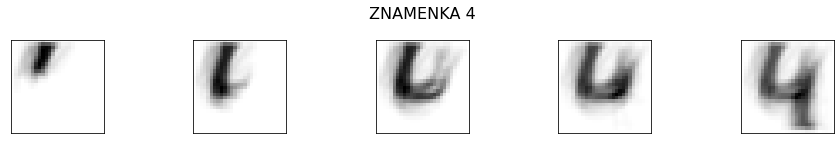

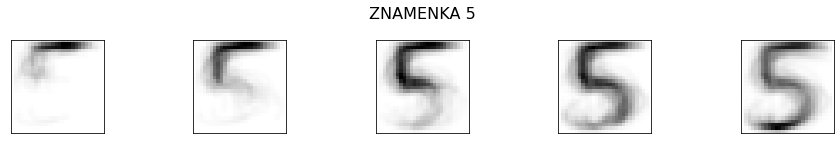

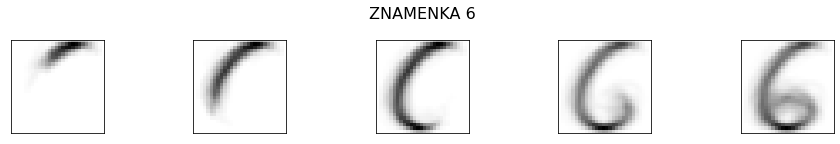

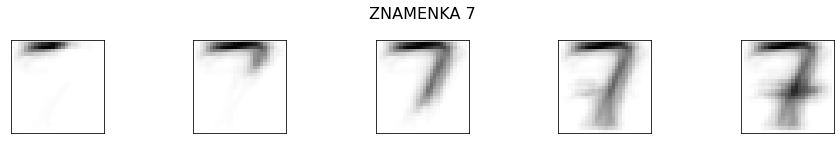

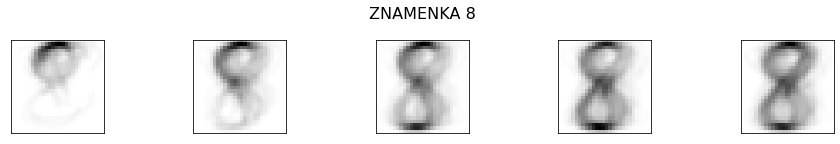

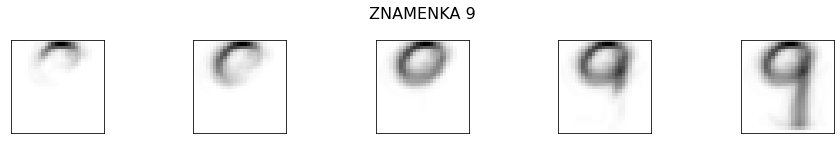

In [23]:
display(HTML('<h2>Komponente tenzorske dekompozicije za svaku znamenku</h2>'))
for j in range(10):
    fig=plt.figure(figsize=(13, 2))
    fig.suptitle(f'ZNAMENKA {j}',fontsize=16)
    for i in range(n_frames):
        plt.subplot(1, n_frames, i + 1)
        plt.imshow(S[j][0][:,i].reshape(n,n),cmap='gray')
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()

In [24]:
%%time
test_predictions=[]
test_labels=[]
T=defaultdict(list)
for drawing in test:
    test_labels.append(int(drawing.label))
    Z=video_to_tensor(video_creator.transform_one(drawing),base_resolution=300,real_resolution=28,line_width=20)
    frames_list=[]
    for k in range(n_frames):
        frames_list.append(Z[k].flatten())
    Z=np.stack(frames_list, axis=1)
    Z=Z/np.linalg.norm(Z,'fro')
    R=[]
    for j in range(10):
        E=1-sum((np.trace(S[j][k].T @ Z))**2 for k in range(80))
        R.append(E)
    test_predictions.append(np.argmin(R))
    T[np.argmin(R)].append(Z[:,4].reshape(n,n))

Wall time: 10.1 s


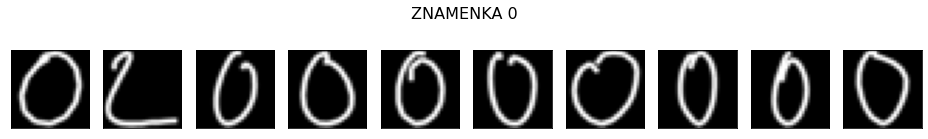

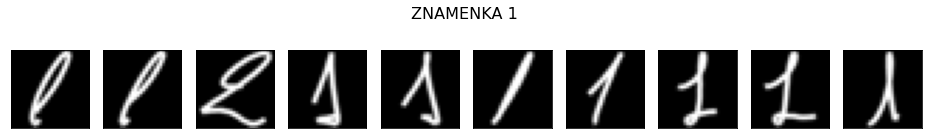

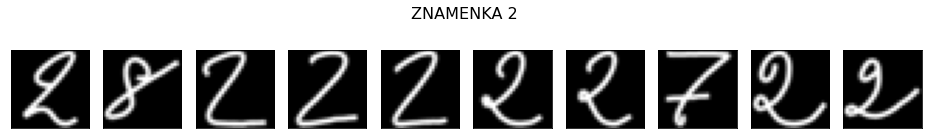

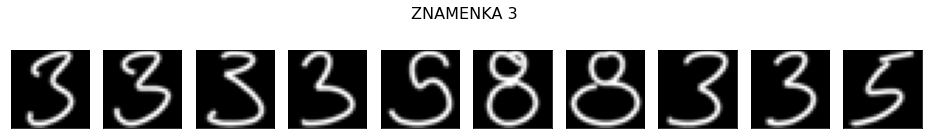

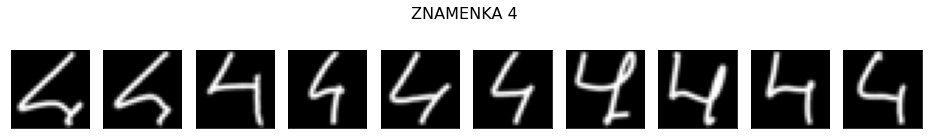

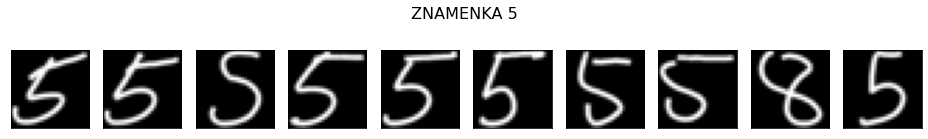

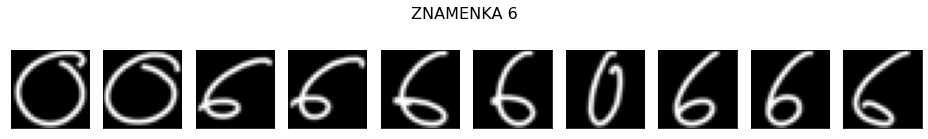

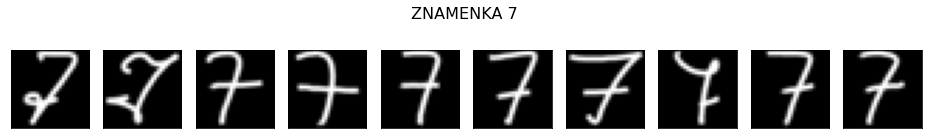

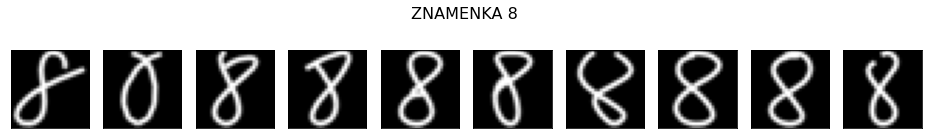

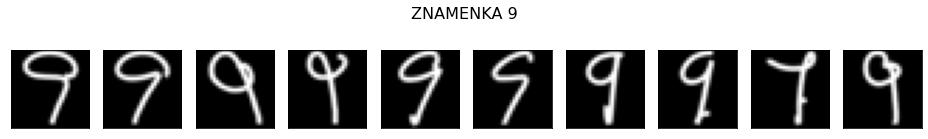

In [25]:
display(HTML('<h2>Predviđene znamenke</h2>'))
for i in range(10):
    fig=plt.figure(figsize=(13, 2))
    fig.suptitle(f'ZNAMENKA {i}',fontsize=16)
    for j in range(10):
        plt.subplot(1, 10, j + 1)
        plt.imshow(T[i][j],cmap='gray')
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()

In [26]:
print('Točnost je',round(np.sum((np.array(test_labels)==np.array(test_predictions)))/len(test)*100,1),'%.')

Točnost je 90.8 %.


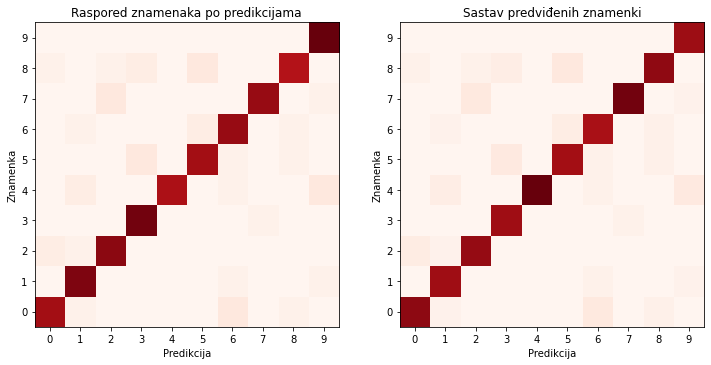

In [27]:
plot_results(pd.Series(test_labels), pd.Series(test_predictions))